## Class 1: Introduction to Data Analysis

### Data Analysis and Regression
Tobias Rodriguez del Pozo, Fall 2025

### Class Information

- Meeting Time: Sundays, 4-7pm Chicago Time on Zoom
- Homework: Weekly problems sets, released after class, due the following Sunday before class.
- Instructor Email (for any questions): tobiasdelpozo@uchicago.edu
- Office Hours: By appointment (just email me!)
- Course GitHub Repository: https://github.com/tobiasdelpozo/data-analysis-2025

### Grading and Homework
- Homework Assignments: 90% of the final grade. These will consist of problems due before class the following week, and we will aim to get them back to you within a week. The grader for the course is Younghun (hun@uchicago.edu), and please reach out to either of us if you have any questions about the homework.
- Participation: 10% of the final grade. This will be based on in-class participation, questions, and engagement. Note that if you're unable to attend the live sessions, you can still get full participation by engaging with the material asynchronously (e.g., asking questions on GitHub issues).
- Remember: The homework is designed to reinforce the concepts covered in class, and ensure that you're prepared for the more difficult problems in the program. If you find yourself struggling, please reach out to me!

### Technology

This class heavily relies on Python programming, with the use of LaTeX for mathematical notation. Familiarity with the basic Python data science stack (NumPy, pandas, matplotlib, scikit-learn, statsmodels) is recommended, but not required.

I use Python 3.14. You can download it either from the [official website](https://www.python.org/downloads/), or through homebrew (Mac), apt (Linux). I use a Mac so you can run `brew install python@3.14` to install it.

For package management, I use `venv` (built-in to Python) and `pip`. You can create a virtual environment for this course by running:

```bash
python3 -V  # to check you have python 3 installed, and ideally 3.14
python3 -m venv environment-name
source environment-name/bin/activate
pip install -r /path/to/requirements.txt
```

You can find the `requirements.txt` file in the course GitHub repository.

I use VSCode as my code editor, you can download it from [here](https://code.visualstudio.com/), or using homebrew. It has a lot of great extensions and customizability.

Basic familiarity with Git and GitHub is also recommended, as I will be sharing code and problem sets through there. We will also use GitHub issues for any questions you might have over the next 4 weeks.

If you're unfamiliar with any of these technologies, either reach out to me, or use Google or an AI tool of your choosing (my personal favorite is Gemini 3.0 Pro from Google). These are well-documented tools with a lot of online resources, though you may run into uncharted territory depending on your operating system and setup.

### Syllabus Outline
- **Class 1**: Introduction to (financial) data analysis, volatility, correlation, bias-variance tradeoff, and introduction to least squares.
- **Class 2**: Regression diagnostics: residuals, influential points, and inference.
- **Class 3**: Time series and beyond vanilla least squares.
- **Class 4**: Other analysis techniques: PCA, clustering, boosting, bagging.

### Class 1: Introduction to Data Analysis

#### Motivation

(Quantitative) finance can be boiled down to:

$$
p_{t+1} = f(\vec{p}, \mathbf{X})
$$

We want to predict the price (or return) of something at some time in the future ($t+1$), using past prices ($\vec{p}$), and other features ($\mathbf{X}$). Another formulation would be:

$$
p_{t} = e^{-r{n}}\mathbb{E}[p_{t + n}] \rightarrow \tilde{p}_{t} = e^{-rn}f(\vec{p}, \mathbf{X})
$$

That is, the price of any asset *now*, is equal to the discounted expected value of that asset at some point in the future ($t+n$). Some examples of this (and don't worry if you don't know what they mean):

- Option prices: Black-Scholes is *exactly* the discounted expected payoff of an option at expiry (under the risk-neutral measure).
- Bonds: A bond price is equal to the discounted coupon plus principal at maturity.
- M&A Deals, VC, PE: A deal price should be equal to the discounted expected cashflows (DCF model).

So really these are two sides of the same coin: if I have some prediction (expectation) of prices at time $t+n$, I can back-out what the current price should be at time $t$. If there is a discrepancy between my price and what the market price is, I can put on a profitable trade.

Another useful concept is *risk* (variance/volatility). One way to think about risk is uncertainty around our prediction. This series of 4 reviews is going to cover techniques we can use for both of these.

One way to think about this would be:

$$
p_{t+1} = f(\vec{p}, \mathbf{X}) \pm \epsilon
$$

#### References

The material for these sessions uses the following sources heavily, and I encourage any of you wanting to dig deeper into any topic presented to leverage the following:

1. The Elements of Statistical Learning ("ELS")
2. Pattern Recognition and Machine Learning ("Bishop")
3. Probabilistic Machine Learning ("Murphy")

(there is a reason there is shorthand for their names)

The resource I drew on most heavily for this course is ELS, which is available [here](https://hastie.su.domains/ElemStatLearn/).

#### Dual Goals

Typically, one encounters large datasets, with many features, and we normally want to achieve two things:
1. Understand the data ourselves, i.e. make it human-interpretable. We want to be able to understand the "shape" of the data, what features might be important, and how they relate to one another.
2. Learn from the data in a systematic way, i.e. build models that can predict future outcomes.


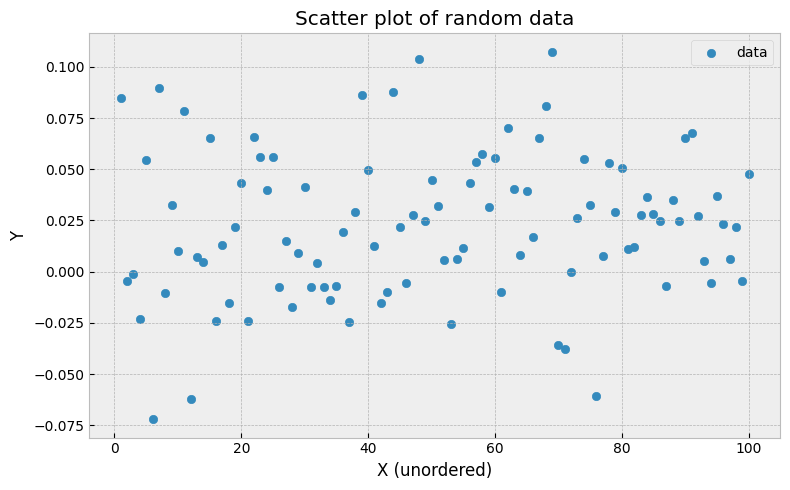

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.neighbors import KNeighborsRegressor


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 5)
np.random.seed(1)

ys = np.random.normal(loc=0.02, scale=0.04, size=100)
xs = np.arange(1, 101, step=1)

plt.scatter(x=xs, y=ys, label="data")
plt.xlabel("X (unordered)")
plt.ylabel("Y")
plt.title("Scatter plot of random data")
plt.legend()
plt.tight_layout()

The above dataset, to my eye, looks like a total mess. The first thing we might want to try is to understand what "on average" the data looks like. 

So we can take the mean:

$$
\bar{x} = \frac{1}{N} \sum_{i=0}^{n} x_i
$$



In [3]:
display(np.mean(ys))

np.float64(0.022423314083027952)

Okay, so now we know that for the average point, it takes a value of 0.0224...

The second thing we might ask ourselves is how "spread out" the data points are around this mean. So, we can take the variance of our points:

$$
\sigma^2 = \frac{1}{N - 1} \sum_{i=0}^{n}(x_i - \bar{x})^2
$$

What units is this in? $x^2$...this is not super intuitive. However, we can take the square-root to get it back into the original $x$ units.

$$
\sigma = \sqrt{\frac{1}{N - 1} \sum_{i=0}^{n}(x_i - \bar{x})^2}
$$

In [4]:
display(np.var(ys, ddof=1))

np.float64(0.0012662650874903703)

In [5]:
display(np.std(ys, ddof=1))

np.float64(0.03558461869249649)

Great, so now I know that my points are on average ~0.0224, and are "spread out" by 0.0355. So I might expect a "typical" point to be between -0.02 and 0.06.

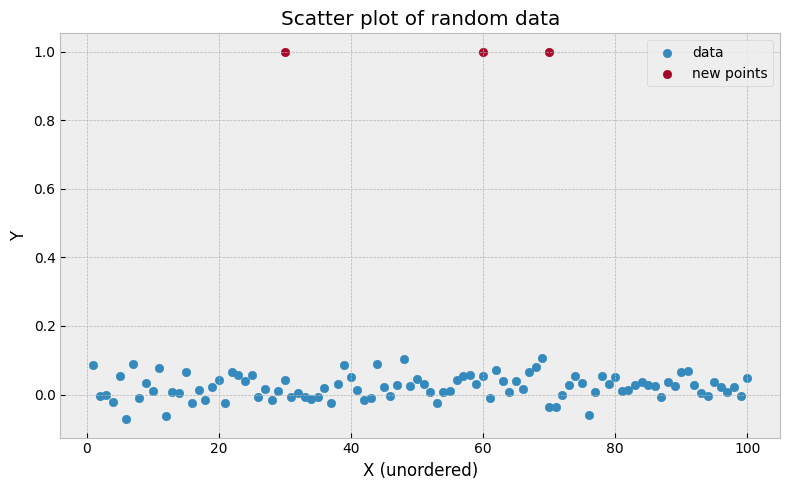

In [6]:
plt.scatter(x=xs, y=ys, label="data")
plt.scatter(x=[30, 60, 70], y=[1, 1, 1], label="new points")
plt.xlabel("X (unordered)")
plt.ylabel("Y")
plt.title("Scatter plot of random data")
plt.legend()
plt.tight_layout()

In [7]:
display((np.mean(ys) * 100 + 3) / 103)

np.float64(0.050896421439832966)

With 3 outliers alone...my mean just doubled? How might I fix this?

Something helpful, which is robust to outliers is the median:

$$
x_{\text{median}} = x_{\frac{n+1}{2}}
$$

So the "middle" point.

In [8]:
display(np.median(ys))

np.float64(0.02256295646249177)

Phew! That dealt with those 3 outliers throwing off our mean. Why don't we just use the median always?

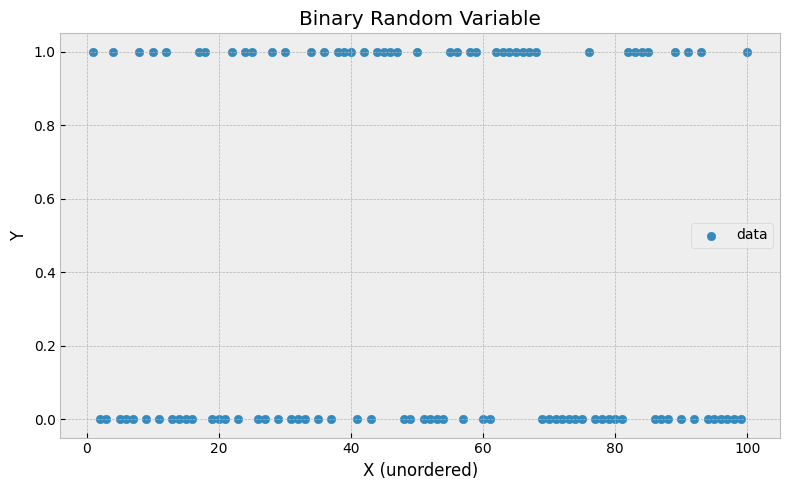

In [9]:
ys = np.random.randint(low=0, high=2, size=100)
plt.scatter(xs, ys, label="data")
plt.xlabel("X (unordered)")
plt.ylabel("Y")
plt.title("Binary Random Variable")
plt.legend()
plt.tight_layout()

In [10]:
print(f"Median: {np.median(ys)}")
print(f"Mean: {np.mean(ys)}")
print(f"Standard Deviation {np.std(ys, ddof=1):.2f}")

Median: 0.0
Mean: 0.43
Standard Deviation 0.50


Both of these are kind of bad.

Specifically, the median seems to imply that the average data point is 0...which is not true. The mean seems to imply that the average data point is 0.46, which is also misleading (no data point is remotely close to 0.46). Additionally, the standard deviation seems to imply that a "typical" point is around 0.5 away from the mean -- which is kind of true? What does this tell us?

That the choice of metrics should be informed by the *distribution* of the data. That is, if my data is either 0s or 1s, it probably doesn't make sense to use the median or mean to describe the shape of it. However, if my data is somewhat clustered/continuous then maybe I should think about using the mean. If my data has outliers, it could be a good idea to think about using the median.

Fortunately, in finance if we're thinking about prices, we can assume that they are lognormally distributed, and therefore log-returns are *normally* distributed. The other thing we have on our side is that if we have a lot of data points, we might see convergence to the normal distribution (Central Limit Theorem/Law of Large Numbers). Note that with a lot of data the mean and median will converge to the same value, and also sample standard deviation/volatility will converge to the true standard deviation/volatility ($N$ vs. $N-1$).

There is a lot to say on distribution fitting, but that is less applicable here.

### More than One Variable

Things get much more interesting when we introduce more than one variable. Note that this isn't necessarily *different* data, my "other variable" could just be a lead/lag of my single variable! And in particular, for time series, my "x" values are timestamps and my "y" values are my data.

What about two variables? $X, Y$?

We can describe them using mean and volatility, but what about the relationship between the two?

#### Supervised Learning

If we have a dataset with inputs $X$, and outputs $Y$ (again, note that $Y$ could just be a lead of $X$, or $X$ could just be timestamps), we can try to learn a function $f$ such that:
$$
Y = f(X) + \epsilon
$$
So that given some $X$ we can predict $Y$. This is called supervised learning, because we have "labels" (the $Y$ values) that we want to predict.

#### How do we measure success?

As stated above, we want to learn a function $f$ such that:
$$
\hat{\theta} = \arg\min_{\theta} f(X, y; \theta)
$$

The first question that arises is: how do we measure success? That is, under what criteria do we say that the model is good? We will see in Session 3 that the decision is non-trivial, but let's explore a few simple options now.

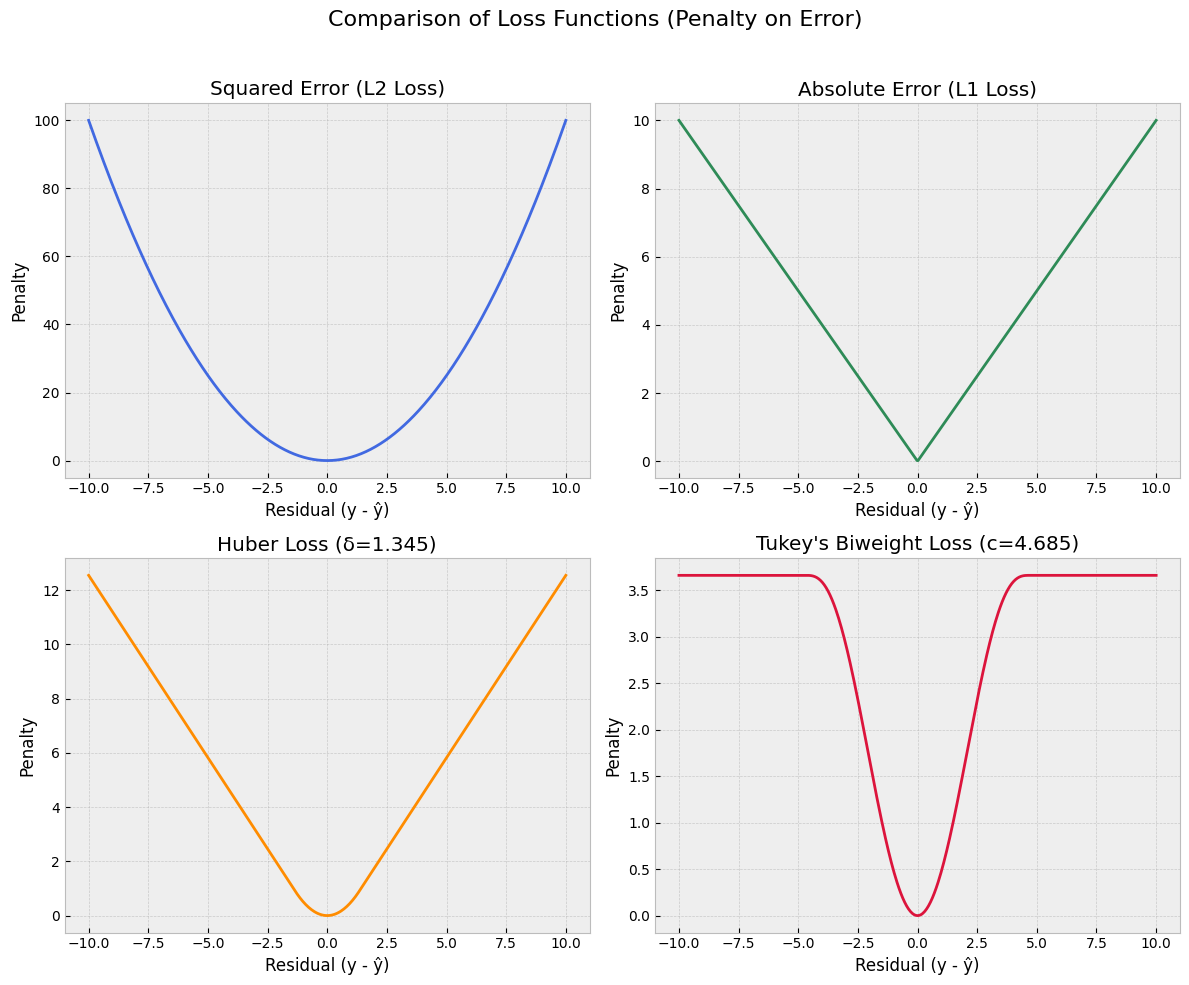

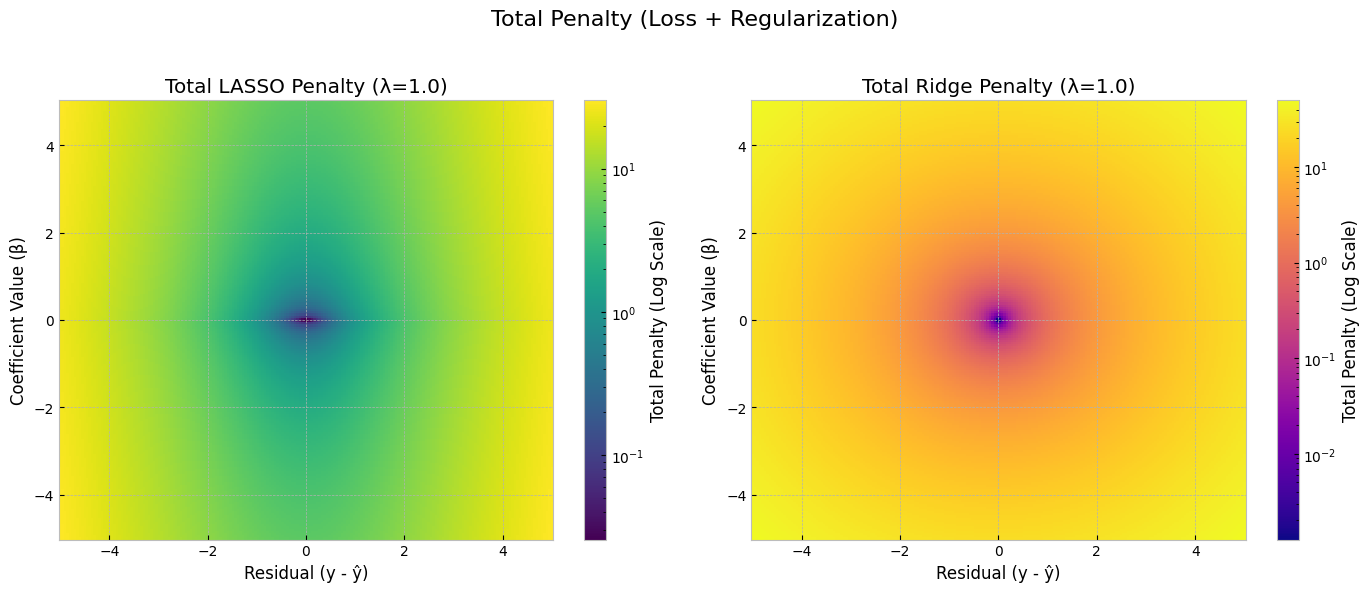

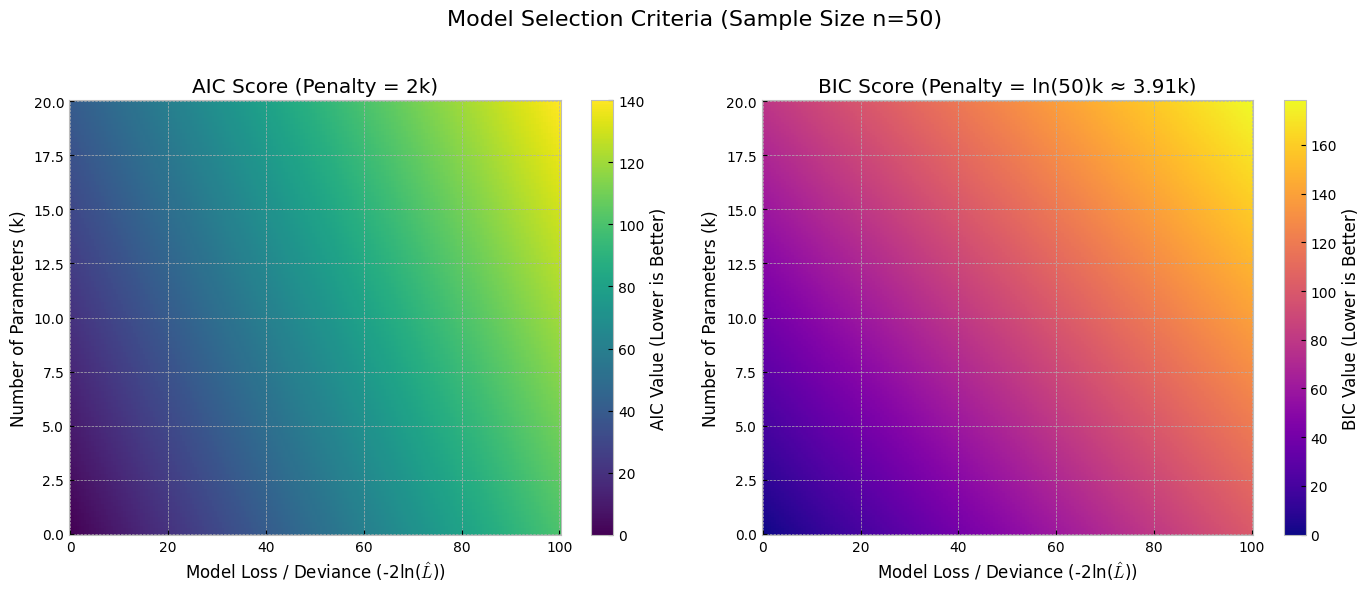

In [ ]:
# Generate a range of residual values (y - y_hat)
residuals_1d = np.linspace(-10, 10, 500)

# 1. Squared Error (L2 Loss)
squared_error = residuals_1d**2

# 2. Absolute Error (L1 Loss)
absolute_error = np.abs(residuals_1d)

# 3. Huber Loss
# This loss is quadratic for small errors and linear for large errors.
# It's less sensitive to outliers than squared error.
delta = 1.345  # A common value for 95% efficiency on a normal distribution
huber_loss = np.where(
    np.abs(residuals_1d) <= delta,
    0.5 * residuals_1d**2,
    delta * (np.abs(residuals_1d) - 0.5 * delta),
)

# 4. Tukey's Biweight Loss (Tukey's bisquare)
# This is a robust loss function that gives zero penalty to very large errors (outliers).
c = 4.685  # A common value for 95% efficiency on a normal distribution
tukey_loss = np.where(
    np.abs(residuals_1d) <= c,
    (c**2 / 6) * (1 - (1 - (residuals_1d / c) ** 2) ** 3),
    c**2 / 6,
)


# Create the plot for Loss Functions
fig1, axs1 = plt.subplots(2, 2, figsize=(12, 10))
fig1.suptitle("Comparison of Loss Functions (Penalty on Error)", fontsize=16)

# Plot Squared Error
axs1[0, 0].plot(residuals_1d, squared_error, color="royalblue")
axs1[0, 0].set_title("Squared Error (L2 Loss)")
axs1[0, 0].set_xlabel("Residual (y - ŷ)")
axs1[0, 0].set_ylabel("Penalty")
axs1[0, 0].grid(True, linestyle="--", alpha=0.6)

# Plot Absolute Error
axs1[0, 1].plot(residuals_1d, absolute_error, color="seagreen")
axs1[0, 1].set_title("Absolute Error (L1 Loss)")
axs1[0, 1].set_xlabel("Residual (y - ŷ)")
axs1[0, 1].set_ylabel("Penalty")
axs1[0, 1].grid(True, linestyle="--", alpha=0.6)

# Plot Huber Loss
axs1[1, 0].plot(residuals_1d, huber_loss, color="darkorange")
axs1[1, 0].set_title(f"Huber Loss (δ={delta})")
axs1[1, 0].set_xlabel("Residual (y - ŷ)")
axs1[1, 0].set_ylabel("Penalty")
axs1[1, 0].grid(True, linestyle="--", alpha=0.6)

# Plot Tukey's Biweight Loss
axs1[1, 1].plot(residuals_1d, tukey_loss, color="crimson")
axs1[1, 1].set_title(f"Tukey's Biweight Loss (c={c})")
axs1[1, 1].set_xlabel("Residual (y - ŷ)")
axs1[1, 1].set_ylabel("Penalty")
axs1[1, 1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# --- Part 2: Regularization Penalty Heatmaps ---

# Generate ranges for residuals and coefficient values
residuals_2d = np.linspace(-5, 5, 200)
beta_values = np.linspace(-5, 5, 200)
lambda_param = 1.0  # Regularization strength parameter

# Create a meshgrid to evaluate the penalty at each point
R, B = np.meshgrid(residuals_2d, beta_values)

# Calculate the base loss (Squared Error) across the grid
loss_grid = R**2

# 1. Total LASSO Penalty (Loss + L1 Regularization)
total_lasso_penalty = loss_grid + (lambda_param * np.abs(B))

# 2. Total Ridge Penalty (Loss + L2 Regularization)
total_ridge_penalty = loss_grid + (lambda_param * B**2)

# Create the plot for Regularization Penalty Heatmaps
fig2, axs2 = plt.subplots(1, 2, figsize=(14, 6))
fig2.suptitle("Total Penalty (Loss + Regularization)", fontsize=16)

# Plot LASSO Penalty Heatmap
im1 = axs2[0].pcolormesh(R, B, total_lasso_penalty, cmap="viridis", norm=LogNorm())
axs2[0].set_title(f"Total LASSO Penalty (λ={lambda_param})")
axs2[0].set_xlabel("Residual (y - ŷ)")
axs2[0].set_ylabel("Coefficient Value (β)")
fig2.colorbar(im1, ax=axs2[0], label="Total Penalty (Log Scale)")

# Plot Ridge Penalty Heatmap
im2 = axs2[1].pcolormesh(R, B, total_ridge_penalty, cmap="plasma", norm=LogNorm())
axs2[1].set_title(f"Total Ridge Penalty (λ={lambda_param})")
axs2[1].set_xlabel("Residual (y - ŷ)")
axs2[1].set_ylabel("Coefficient Value (β)")
fig2.colorbar(im2, ax=axs2[1], label="Total Penalty (Log Scale)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 1. Define the ranges for the axes
# Loss represents the deviance or -2*log-likelihood
loss_values = np.linspace(0, 100, 200)
# k represents the number of parameters in the model
k_values = np.linspace(0, 20, 200)
# Sample size n (fixed for this visualization to calculate BIC)
n = 50

# 2. Create a meshgrid to evaluate the criteria at each point
L, K = np.meshgrid(loss_values, k_values)

# 3. Calculate AIC Score (Loss + 2k)
# Formula: AIC = -2ln(L_hat) + 2k
# We treat the x-axis 'L' as the -2ln(L_hat) term.
aic_grid = L + (2 * K)

# 4. Calculate BIC Score (Loss + ln(n)k)
# Formula: BIC = -2ln(L_hat) + ln(n)k
bic_grid = L + (np.log(n) * K)

# 5. Create the plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f"Model Selection Criteria (Sample Size n={n})", fontsize=16)

# Plot AIC Heatmap
im1 = axs[0].pcolormesh(L, K, aic_grid, cmap="viridis", shading="auto")
axs[0].set_title("AIC Score (Penalty = 2k)")
axs[0].set_xlabel("Model Loss / Deviance (-2ln($\hat{L}$))")
axs[0].set_ylabel("Number of Parameters (k)")
fig.colorbar(im1, ax=axs[0], label="AIC Value (Lower is Better)")

# Plot BIC Heatmap
im2 = axs[1].pcolormesh(L, K, bic_grid, cmap="plasma", shading="auto")
axs[1].set_title(f"BIC Score (Penalty = ln({n})k ≈ {np.log(n):.2f}k)")
axs[1].set_xlabel("Model Loss / Deviance (-2ln($\hat{L}$))")
axs[1].set_ylabel("Number of Parameters (k)")
fig.colorbar(im2, ax=axs[1], label="BIC Value (Lower is Better)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

These graphs illustrate the "zoo" of different functions we might want to use to measure success of a model. We can penalize the model not only on how far off its predictions are (from the true values), but also on the complexity of the model itself (to avoid overfitting).

#### A Simple Model

One of the simplest models we can use is a "nearest neighbor" model. That is, given some $X$, we can find the closest $k$ points in our training data, and average their $Y$ values to get a prediction.

$$
\hat{Y} = \frac{1}{k} \sum_{i \in \text{NN}(X, k)} Y_i
$$

In [19]:
X_train = np.sort(5 * np.random.rand(40, 1), axis=0)
y_train = np.sin(X_train).ravel()

y_train[::5] += 1 * (0.5 - np.random.rand(8))
X_test = np.linspace(0, 5, 500)[:, np.newaxis]
knn_regressor = KNeighborsRegressor(n_neighbors=1, weights="uniform")
knn_5 = KNeighborsRegressor(n_neighbors=5, weights="uniform")
knn_40 = KNeighborsRegressor(n_neighbors=40, weights="uniform")
knn_regressor.fit(X_train, y_train)
knn_5.fit(X_train, y_train)
knn_40.fit(X_train, y_train)

y_pred = knn_regressor.predict(X_test)
y_pred_5 = knn_5.predict(X_test)
y_pred_40 = knn_40.predict(X_test)

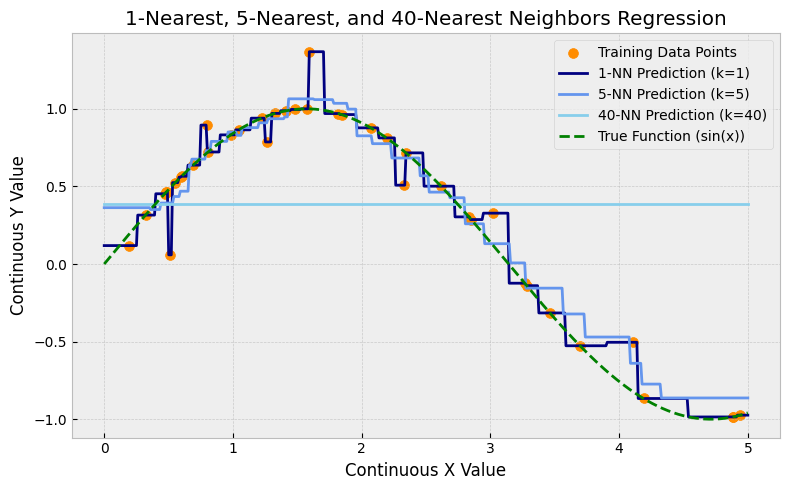

In [21]:
plt.scatter(X_train, y_train, color="darkorange", label="Training Data Points", s=50)

plt.plot(X_test, y_pred, color="navy", label="1-NN Prediction (k=1)", linewidth=2)

plt.plot(
    X_test, y_pred_5, color="cornflowerblue", label="5-NN Prediction (k=5)", linewidth=2
)

plt.plot(
    X_test, y_pred_40, color="skyblue", label="40-NN Prediction (k=40)", linewidth=2
)

# Plot the true function
plt.plot(
    X_test,
    np.sin(X_test),
    color="green",
    label="True Function (sin(x))",
    linewidth=2,
    linestyle="--",
)

plt.xlabel("Continuous X Value")
plt.ylabel("Continuous Y Value")
plt.title("1-Nearest, 5-Nearest, and 40-Nearest Neighbors Regression")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

The model above has exactly 1 parameter: $k$, the number of nearest neighbors to consider. Note how the dark-blue line (1-NN) is very "wiggly" and follows the data very closely, while the sky-blue line is too smooth and misses all of the data.

Which model is likely to perform better on new data?

How do we think about the trade-off between how "wiggly" our model is, and how "smooth" it is?

#### Bias Variance Tradeoff

Well let's think about the two extremes:

- The 1-NN model fits the data extremely well, specifically, all points in our training data are perfectly predicted. This means that if we look at the error on the training data, it is 0, no matter what our loss function is.
- The 40-NN model fits the data very poorly. It misses most of the data points by a wide margin, since it is just the sample average in the example above (a single flat line).

But what about new data?

- The 1-NN model is likely to perform poorly on new data, since it so wiggly that our predictions are very likely to change dramatically with small changes in the input data. We can think of this as the model being unstable.
- The 40-NN model is likely to change much less on new data, since it so smooth (remember, it's just the sample average), so we can expect it to be more stable.

This trade-off between how well the model fits the training data (bias), and how stable the model is to new data (variance) is called the *bias-variance tradeoff*. The goal of data analysis is to find a model that balances these two competing objectives.

We want to find a model that is not too wiggly (high variance), but also not too smooth (high bias). The optimal model is somewhere in between these two extremes.

How can we formalize this trade-off? Well, let's suppose that we choose squared error as our loss function:

$$
L(Y, \hat{Y}) = (Y - \hat{Y})^2 = (Y - f(X))^2
$$

We can then decompose the error into three components:
1. Irreducible Error: This is the error that is inherent in the data, and cannot be reduced by any model. It is the variance of the noise term $\epsilon$. That is, no matter how good our model is, there will always be some error due to the inherent randomness in the data.
2. Bias: We can think of this as the error due to the model being too simple. That is, if our model is too smooth, it will not be able to capture the true relationship between $X$ and $Y$, leading to systematic errors in our predictions.
3. Variance: We can think of this as the error due to the model being too complex or overfitting. That is, if our model is too complex/has high variance, it will fit the training data very well, but will not generalize well to new data, leading to large errors on unseen data.

And therefore, the expected squared error can be decomposed as:
$$
\mathbb{E}[(Y - \hat{Y})^2] = \sigma^2_{\epsilon} + \text{Bias}^2 + \text{Variance}
$$

Said differently:

$$
\text{MSE} = \text{Irreducible Error} + \text{Bias}^2 + \text{Variance}
$$

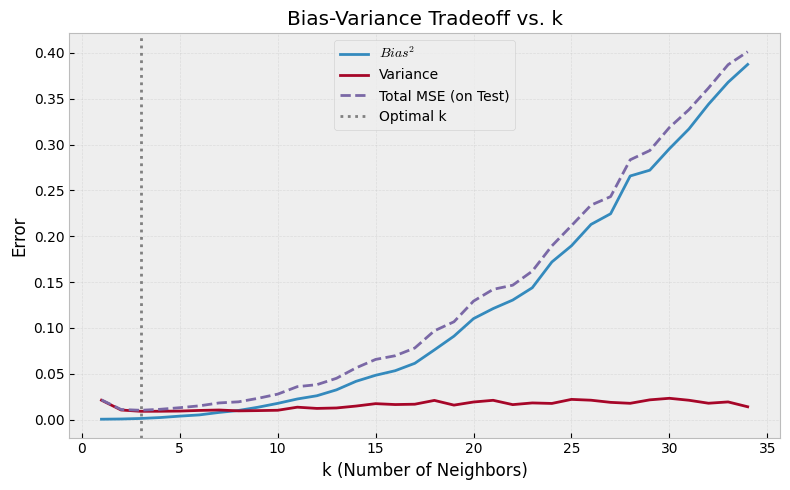

In [ ]:
def generate_data(n_samples=40):
    """
    Generates data using the exact logic provided in the prompt.
    """
    # Fix seed inside to ensure replicability if needed,
    # but for simulation we want random variations.
    X = np.sort(5 * np.random.rand(n_samples, 1), axis=0)
    y = np.sin(X).ravel()

    # Add noise to every 5th element
    # Note: Using len(y[::5]) to ensure shapes match if n_samples changes
    noise_count = len(y[::5])
    y[::5] += 1 * (0.5 - np.random.rand(noise_count))

    return X, y


# Ground Truth function (noiseless)
def f_true(x):
    return np.sin(x)


X_test = np.linspace(0, 5, 500)[:, np.newaxis]
y_test_true = f_true(X_test).ravel()

# Simulation settings
n_repeats = 100  # Number of datasets to simulate to estimate E[y_hat]
k_values = range(1, 35)  # Analyze k from 1 to 35

# Store results
avg_bias_squared = []
avg_variance = []
avg_mse = []

for k in k_values:
    # Matrix to store predictions for this k across all simulations
    # Shape: (n_repeats, n_test_points)
    predictions = np.zeros((n_repeats, len(X_test)))

    for i in range(n_repeats):
        # 1. Generate a new realization of the training data
        # (simulating the world where we drew a different dataset)
        X_train_sim, y_train_sim = generate_data()

        # 2. Fit kNN
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train_sim, y_train_sim)

        # 3. Predict on test set
        predictions[i, :] = knn.predict(X_test).ravel()

    # --- Calculate Bias^2, Variance, and MSE for this k ---

    # The "Main Prediction" (Expected value of the estimator)
    # E[y_hat] ≈ Average of predictions across simulations
    y_main_prediction = np.mean(predictions, axis=0)

    # Bias^2 = (E[y_hat] - y_true)^2
    bias_sq_per_point = (y_main_prediction - y_test_true) ** 2
    bias_sq = np.mean(bias_sq_per_point)

    # Variance = E[ (y_hat - E[y_hat])^2 ]
    var_per_point = np.var(predictions, axis=0)
    variance = np.mean(var_per_point)

    # MSE = Bias^2 + Variance + Irreducible Error
    # Here we calculate MSE directly against the true function to verify
    # (Note: This matches Bias^2 + Var theoretically, ignoring irreducible error term calculation for now)
    mse_total = np.mean((predictions - y_test_true.reshape(1, -1)) ** 2)

    avg_bias_squared.append(bias_sq)
    avg_variance.append(variance)
    avg_mse.append(mse_total)

plt.figure(figsize=(8, 5))

# --- Plot: Bias-Variance Tradeoff Curves ---
plt.plot(k_values, avg_bias_squared, label="$Bias^2$", linewidth=2)
plt.plot(k_values, avg_variance, label="Variance", linewidth=2)
plt.plot(k_values, avg_mse, label="Total MSE (on Test)", linestyle="--", linewidth=2)

plt.axvline(
    x=k_values[np.argmin(avg_mse)], color="gray", linestyle=":", label="Optimal k"
)

plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Error")
plt.title("Bias-Variance Tradeoff vs. k")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_k = k_values[np.argmin(avg_mse)]

#### A Second Simple Model

kNN is great in the sense that it makes no assumptions about the data, but it is also very limited and can be prone to overfitting. What happens if we believe that our data has some underlying relationship between $X$ and $Y$ that is more structured?

Specifically, what if we believe that the relationship is linear?

Correlation:

$$
\rho = \frac{\text{Cov}(X,Y)}{\sqrt{\text{Var}(X)}\sqrt{\text{Var}{(Y)}}}
$$

Covariance

$$
\text{Cov}(X,Y) = \frac{\sum_{i=0}^{n} (x_i - \bar{x})(y_i - \bar{y})}{N-1}
$$

Interview question: suppose that $\rho = Cov(X,Y) = 0$, are $X$ and $Y$ independent?

In [30]:
x = np.linspace(-1, 1, 100)
y = x**2

np.corrcoef(x, y)[0, 1]

np.float64(2.253645025632127e-16)

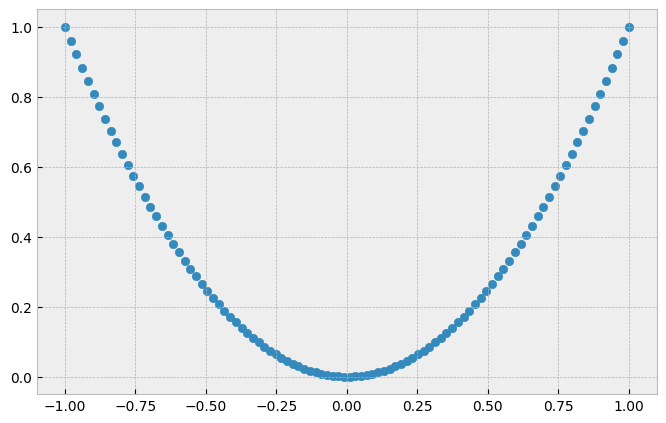

In [31]:
plt.scatter(x, y)

Independence is actually saying something stronger:

$$
X \perp Y \iff \{ \text{Cov}(f(X), g(Y)) = 0 \;\; \forall f, g \}
$$

So to that example, we can just take $x^2$ and we end up with a linear function

In [32]:
np.corrcoef(x**2, y)

array([[1., 1.],
       [1., 1.]])

Thus, we can think as the covariance as being the linear relationship between two variables.

Returning to correlation...why might it be preferred over covariance? Similar to volatility being preferred to variance, the principal benefit is that it's unitless.

To see this let's think of what units covariance is in:

$$
\text{Cov}(X,Y) = \frac{\sum_{i=0}^{n} (x_i - \bar{x})(y_i - \bar{y})}{N-1}
$$

The top part is "XY" units, which is weird! So therefore to get it into a unitless measure which is more intuitive (and comparable across different datasets), we need to divide by something in "X" units, and something in "Y" units, and therefore dividing by the volatilities rescales us.

In [33]:
x = np.linspace(0, 1, 100)
y = x * 100

# Print covariance
cov = np.cov(x, y)[0, 1]
display(cov)

np.float64(8.5875590926096)

In [35]:
# Print correlation
corr = np.corrcoef(x, y)[0, 1]
display(corr)

np.float64(1.0)

Again, if covariance is measuring the linear dependence between two variables, this carries through to correlation as well. Typically, when doing this style of research, one would want to *linearize* the problem where possible.

But, lets suppose that we have some $X$ variables that are correlated with our $y$. There will be a further discussion on why financial data "tends" to do this later in this series.

#### Least Squares

This is an extension from something you've probably seen in middle school, which is the concept of a "line of best fit". We're going to derive and formalize that now.

For a variety of reasons (math is easier, inference is clear and easy), we typically pick least squares. There was also another "hidden" assumption about our loss function I just presented, can anyone spot it?

The choice of $y - \hat{y}$ as our "error"! This is minimizing the vertical distance to our line of best fit, but that is also just a choice. We could have minimized the perpendicular distance to our line as well (for example).

Nevertheless, lets run with our squared penalty.

$$
\hat{\theta} = \argmin f(X, y, \theta) \rightarrow \argmin (y - g(X, \theta))^2
$$



Well, that solves one problem (our loss), but that still doesn't help our choice of prediction function, $g(X, \theta)$, ie. the thing that actually *produces* the $\hat{y}$.

How should we pick this? Well this is the choice of model. One choice could be nearest neighbors, a neural net, etc.

But from our discussion on covariance, we are assuming that there is some *linear* relationship between our $X$ and $y$. Therefore, we want to "scale" some combination of these $X$ variables together to produce a prediction.

$$
\hat{\beta} = \argmin (y - \beta \cdot \bf{X})^2
$$

Phrased differently, our prediction now boils down to:

$$
\hat{y} = \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n
$$

How do we choose $\beta$?

Take the derivative and set to 0!

\begin{align*}
\frac{\partial}{\partial \beta}(y - \beta \cdot \bf{X})^2 &= 0\\
-2\bf{X}^T(y - \bf{X}\beta) &= 0\\
\bf{X}^T(y - \bf{X}\beta) &= 0\\
\bf{X}^T(y - \bf{X}^T\bf{X}\beta) &= 0\\
\bf{X}^Ty - \bf{X}^T\bf{X}\beta &= 0\\
\bf{X}^Ty &= \bf{X}^T\bf{X}\beta\\
\beta &= (\bf{X}^T\bf{X})^{-1}\bf{X}^Ty
\end{align*}

And now that we have our solution, we can get predicted values ($\hat{y}$):

$$
\hat{y} = \bf{X}\beta = \bf{X}(\bf{X}^T\bf{X})^{-1}\bf{X}^Ty
$$

We typically call $\bf{X}(\bf{X}^T\bf{X})^{-1}\bf{X}$ the "hat matrix", because it puts the "hat" on $y$.

Is there anything illegal going on with this proof?

Unfortunately...yes.

What happens if $X$ isn't invertible?

Assuming that $X$ is invertible, lets try to better visualize this.

Interview question: assume that my covariance matrix isn't invertible, how can I still run (vanilla) OLS on my features?

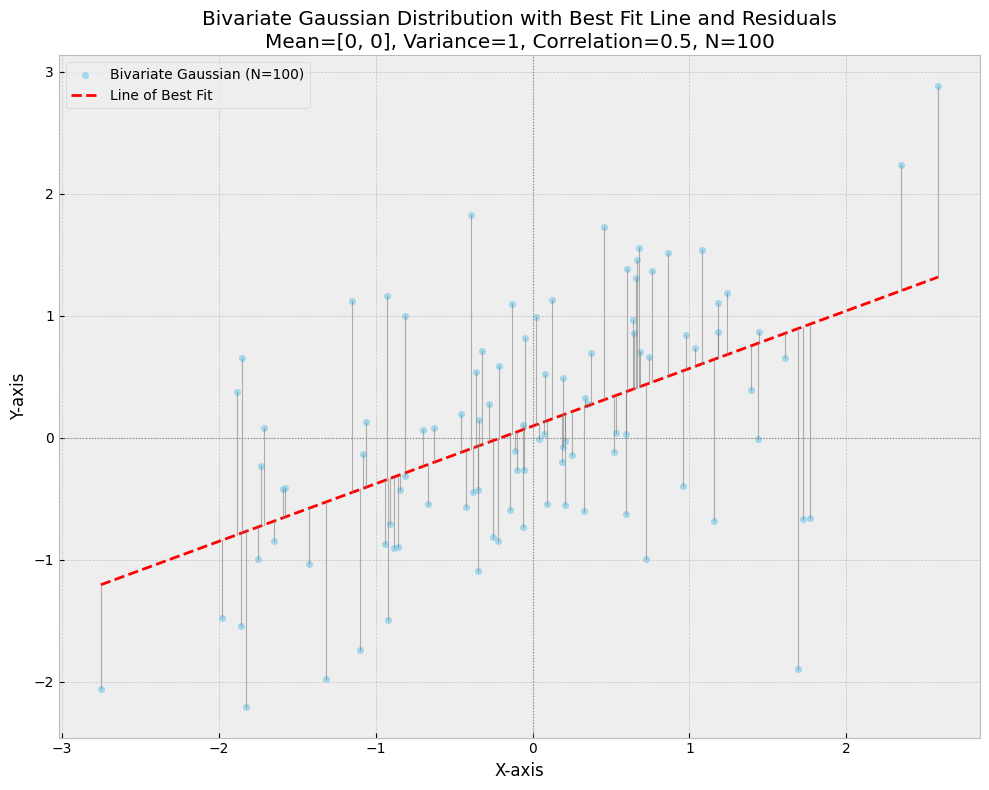

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mean = [0, 0]  # Mean of the distribution (0 for both x and y)
variance = 1  # Unit variance for both x and y
correlation = 0.5  # Correlation between x and y
num_points = 100  # Number of points to draw (changed from 1000 to 100)

# Since var_x = var_y = 1, cov_xy = correlation * 1 * 1 = correlation
covariance_matrix = [
    [variance, correlation * variance],
    [correlation * variance, variance],
]


# Generate points from the bivariate Gaussian distribution
data = np.random.multivariate_normal(mean, covariance_matrix, num_points)

# Separate the x and y coordinates for plotting
x = data[:, 0]
y = data[:, 1]

# Calculate the line of best fit (linear regression)
# np.polyfit(x, y, 1) returns the coefficients [slope, intercept] for a 1st-degree polynomial
slope, intercept = np.polyfit(x, y, 1)

# Create a scatter plot of the generated points
plt.figure(figsize=(10, 8))  # Set the figure size for better visualization
plt.scatter(
    x, y, alpha=0.7, s=20, color="skyblue", label=f"Bivariate Gaussian (N={num_points})"
)

# Create x-values for the line, covering the range of the data
x_line = np.array([min(x), max(x)])
y_line = slope * x_line + intercept
plt.plot(
    x_line, y_line, color="red", linestyle="--", linewidth=2, label="Line of Best Fit"
)

# Add vertical lines from each point to the line of best fit (residuals)
for i in range(num_points):
    x_point = x[i]
    y_point = y[i]
    y_predicted = slope * x_point + intercept

    # Plot a vertical line from (x_point, y_point) to (x_point, y_predicted)
    plt.plot(
        [x_point, x_point],
        [y_point, y_predicted],
        color="gray",
        linestyle="-",
        linewidth=0.8,
        alpha=0.6,
    )

plt.title(
    f"Bivariate Gaussian Distribution with Best Fit Line and Residuals\n"
    f"Mean={mean}, Variance={variance}, Correlation={correlation}, N={num_points}"
)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True, linestyle="--", alpha=0.7)
plt.axhline(
    0, color="grey", linewidth=0.8, linestyle=":"
)  # Add a horizontal line at y=0
plt.axvline(0, color="grey", linewidth=0.8, linestyle=":")  # Add a vertical line at x=0
plt.legend()
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

We can think of this as least squares is "tilting" the line back and forth until we find a slope that works the best. Now that we have this OLS estimator, lets explore some different cases:

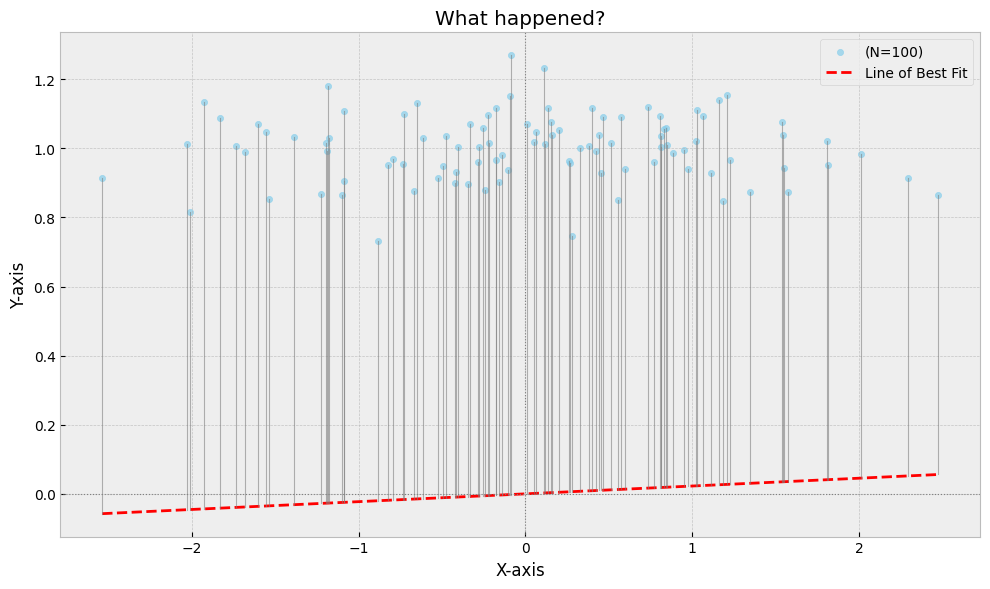

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the bivariate Gaussian distribution
mean = [0, 0]  # Mean of the distribution (0 for both x and y)
variance = 1  # Unit variance for both x and y
correlation = 0.5  # Correlation between x and y
num_points = 100  # Number of points to draw (changed from 1000 to 100)

# Construct the covariance matrix
covariance_matrix = [
    [variance, correlation * variance],
    [correlation * variance, variance],
]

# Generate points from the bivariate Gaussian distribution
data = np.random.multivariate_normal(mean, covariance_matrix, num_points)
data[:, 0] = np.random.normal(
    loc=0, scale=1, size=num_points
)  # Ensure x is normally distributed
data[:, 1] = 1 + np.random.normal(
    loc=0, scale=0.1, size=num_points
)  # Ensure y is normally distributed
# Separate the x and y coordinates for plotting
x = data[:, 0]
y = data[:, 1]

# Calculate the line of best fit (linear regression)
# np.polyfit(x, y, 1) returns the coefficients [slope, intercept] for a 1st-degree polynomial
# Fit without an intercept to ensure the line goes through the origin
slope = sm.OLS(y, x).fit().params[0]

# slope, intercept = np.polyfit(x, y, 1)
# Create a scatter plot of the generated points
plt.figure(figsize=(10, 6))  # Set the figure size for better visualization
plt.scatter(x, y, alpha=0.7, s=20, color="skyblue", label=f"(N={num_points})")

# Plot the line of best fit
# Create x-values for the line, covering the range of the data
x_line = np.array([min(x), max(x)])
y_line = slope * x_line

plt.plot(
    x_line, y_line, color="red", linestyle="--", linewidth=2, label="Line of Best Fit"
)

# Add vertical lines from each point to the line of best fit (residuals)
for i in range(num_points):
    x_point = x[i]
    y_point = y[i]
    y_predicted = slope * x_point
    
    # Plot a vertical line from (x_point, y_point) to (x_point, y_predicted)
    plt.plot(
        [x_point, x_point],
        [y_point, y_predicted],
        color="gray",
        linestyle="-",
        linewidth=0.8,
        alpha=0.6,
    )

plt.title("What happened?")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True, linestyle="--", alpha=0.7)
plt.axhline(
    0, color="grey", linewidth=0.8, linestyle=":"
)  # Add a horizontal line at y=0
plt.axvline(0, color="grey", linewidth=0.8, linestyle=":")  # Add a vertical line at x=0
plt.legend()
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

What happened above?!?! Isn't it supposed to be a straight line?

What's going on is that $y$ has a non-zero *mean*, so when we try to fit a line through the origin it goes terribly.

How do we get around this? We need to add a constant. Consider what happens if we add a constant, and lets only focus on the two parameter case.

$$
y \sim \beta_0 + \beta_1 x 
$$

\begin{align*}
\frac{\partial}{\partial \beta_0} &= -2 \sum_{i=1}^{n}(y_i - \beta_0 - \beta_1 x)\\
\beta_1 \sum_{i=1}^{n}x_i + \beta_0 \cdot n &= \sum_{i=1}^{n}y_i\\
\beta_0 &= \frac{1}{n} \sum_{i=1}^{n}y_i - \beta_1 \cdot \frac{1}{n} \sum_{i=1}^{n}x_i\\
&= \bar{y} - \beta_1 \bar{x}
\end{align*}

So the constant has the effect of "demeaning" our data. To see this suppose that we transform our $x$ to be $\tilde{x} = x - \bar{x}$, and $y$ to be $\tilde{y} = y - \bar{y}$. Then from the equation above, $\beta_0 = \bar{\tilde{y}} - \beta_1 \bar{\tilde{x}} = 0$. In most academic contexts, we typically leave a constant, but in real life one should be thoughtful about when we want to include a constant or not.

The importance of covariance estimates...

$$
\text{Cov}(X,Y) = \frac{\sum_{i=0}^{n} (x_i - \bar{x})(y_i - \bar{y})}{N-1}
$$

Let's think about what $X^TX$ is doing. The each entry is going to be:

$$
(X^TX)_{i,j} = \sum_{k=1}^{n}X_{k,i}X_{k,j}
$$

So therefore $X^TX$ rescaled by $1/(n-1)$ looks pretty similar to a covariance matrix. In fact, de-meaning the data gives us *exactly* the covariance matrix.

$$
(X^TX)_{i,j} = \frac{1}{n-1}\sum_{k=1}^{n}(X_{k,i} - \bar{x}_i)(X_{k,j} - \bar{x}_j)
$$

Additionally, note that because we are just demeaning it (subtracting a constant), it means that if $X$ is non-invertible, it means that it's covariance matrix is non-invertible, which means that we have features that are not unique.

An often overlooked part of finance is this estimation. Specifically, people spend a *lot* of time on having a very good $\mu$, or price prediction, but much less time thinking about the covariance matrix.

#### Measurement Error and the Geometric Interpretation of OLS

Another way to think about what least squares is doing goes back to this line in our derivation:

$$
\bf{X}^T(y - \bf{X}\beta) = 0
$$

And lets remember the definition of a dot-product

$$
\vec{a}\cdot \vec{b}
$$

In the case of above we are taking the dot-product of every row in $X^T$ with the value in $(y - \bf{X}\beta)_i$. Recall that two vectors are orthogonal if their dot product is 0.

Thus, by solving the least squares solution, we are *projecting* $y$ onto a subspace spanned by $X$! And the optimal solution will be when what is "left over" ($y - \hat{y}$) is orthogonal to that subspace.

That is, we are breaking apart $y$ into two components: first, the projection onto the subspace of $X$, and second, a vector which is in the null space of $X$.

$$
y = \hat{y} + \epsilon
$$

Where $\epsilon \perp X$

![image](images/ols_interp.png)

The typical interpretation of this is that if our model is true, then we have some $\hat{y}$, *plus* some measurement error or "random noise".

#### HELP! My features aren't linear, what do I do?

Note that from our setup, we have *assumed* that our features are linearly related ($\text{Cov}(X,Y) \neq 0$). 

But, if they aren't independent, then it follows that there exists some $f,g$ such that $\text{Cov}(f(x), g(y)) \neq 0$. Our job is to extract that $f,g$.

Going back to our example of $y = x^2$, where we found 0 correlation/covariance between them...

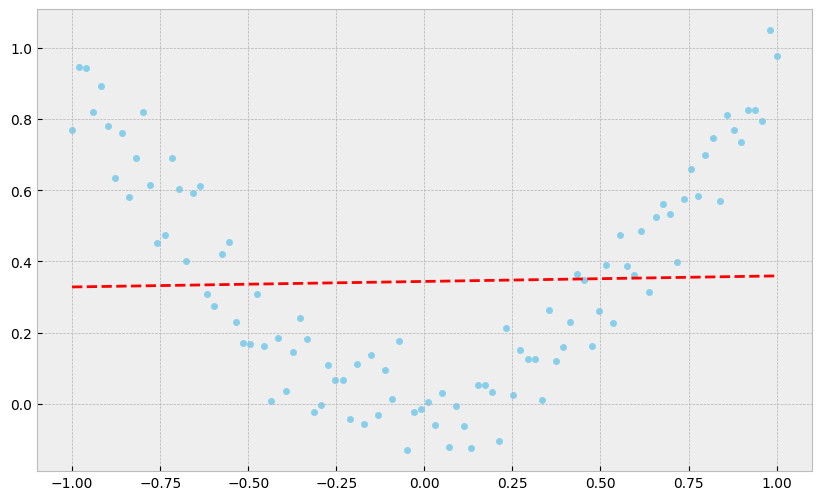

In [38]:
x = np.linspace(-1, 1, 100)
y = x**2 + np.random.normal(0, 0.1, size=x.shape)

# Fit a linear model
slope, intercept = np.polyfit(x, y, 1)

# Create a scatter plot of the data and the line of best fit
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=1, s=20, color="skyblue", label="Data Points")
plt.plot(
    x,
    slope * x + intercept,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Line of Best Fit",
)
plt.show()

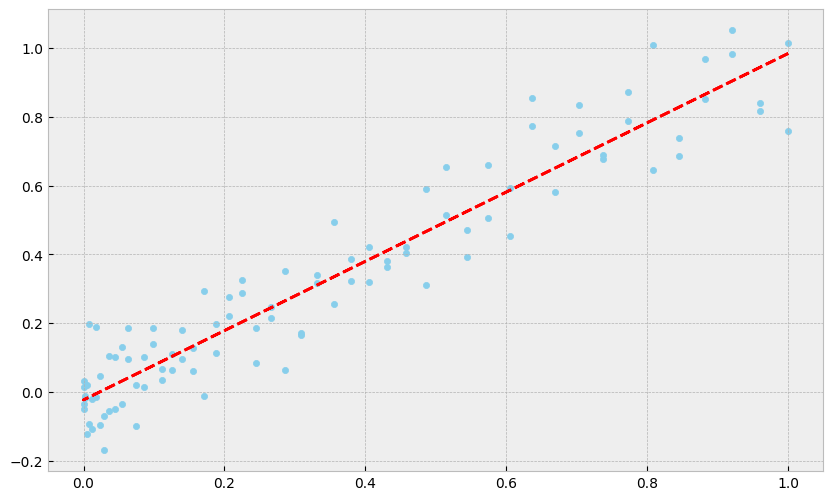

In [39]:
x = np.linspace(-1, 1, 100)
y = x**2 + np.random.normal(0, 0.1, size=x.shape)
x = x**2

# Fit a linear model
slope, intercept = np.polyfit(x, y, 1)

# Create a scatter plot of the data and the line of best fit
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=1, s=20, color="skyblue", label="Data Points")
plt.plot(
    x,
    slope * x + intercept,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Line of Best Fit",
)
plt.show()

So, *feature* transforms is how we can turn a nonlinear problem into a linear one. In industry, smart feature selection and engineering is typically the "secret sauce". The way you could achieve this at a basic level is staring at scatter plots, but there are some common transforms:

In fact, our X-inputs could be:
1. quantitative inputs
2. transforms of quantitative inputs (log, square-root, cosine, etc.)
3. basis expansions (polynomials, splines, etc.)
4. categorical inputs (one-hot encoding, etc.)
5. interactions of the above

And all we need to do is do appropriate transforms to turn it into a linear problem, since all that linear regression imposes is that the output is linear *in beta*, not in $X$. A term that is sometimes used is that $X$ is our *design* matrix, because we get to design it.

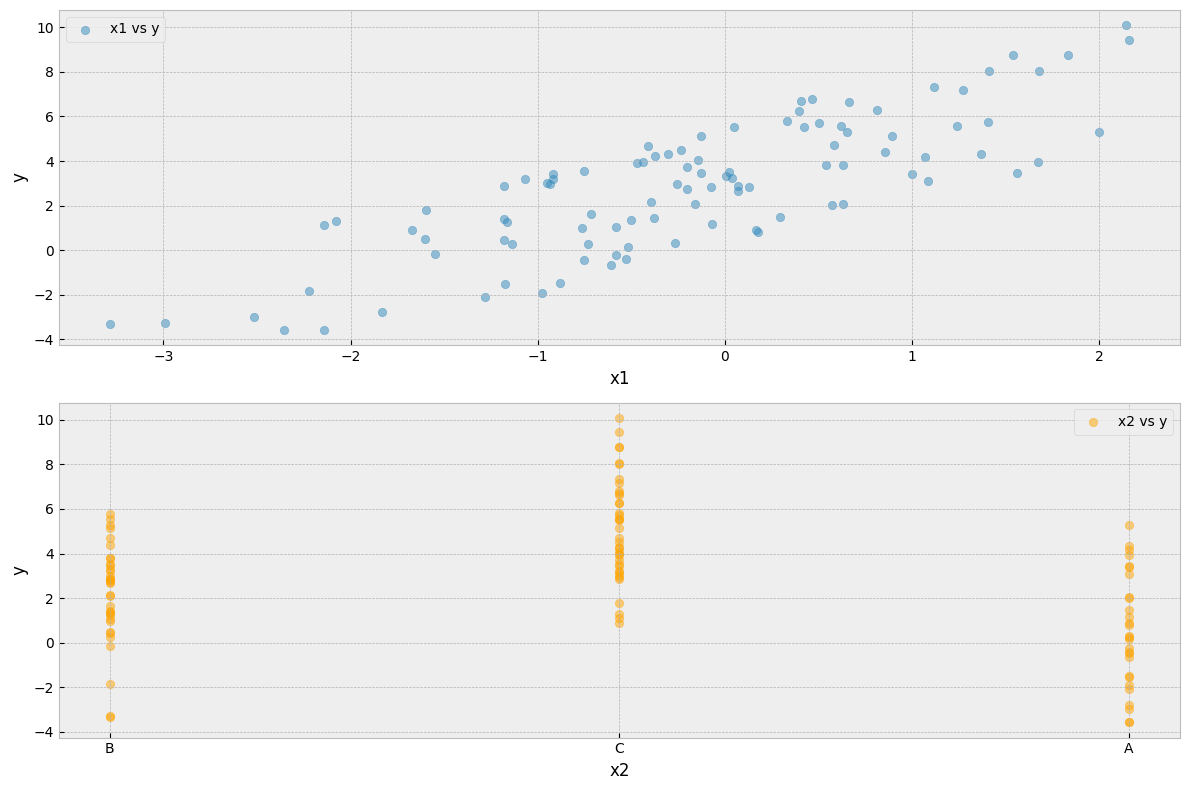

In [40]:
# Let x1 be gaussian
x1 = np.random.normal(loc=0, scale=1, size=100)

# Let x2 be categorical with 3 categories
x2 = np.random.choice(["A", "B", "C"], size=100)

y = (
    2 * x1
    + 1 * (x2 == "A")
    + 3 * (x2 == "B")
    + 5 * (x2 == "C")
    + np.random.normal(0, 0.5, size=100)
)

# Plot scatters of each of the xs against y
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.scatter(x1, y, alpha=0.5, label="x1 vs y")
plt.xlabel("x1")
plt.ylabel("y")
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(x2, y, alpha=0.5, label="x2 vs y", color="orange")
plt.xlabel("x2")
plt.ylabel("y")
plt.legend()

plt.tight_layout()
plt.show()

So it looks like there is some clear relation, but how do I do matrix math with "A", "B", "C" as the inputs?!?

Well, I can use a "one-hot" encoding, where I define 3 new columns instead of "x2". Each one will have a "1" for that feature, and then a "0" for the other two features.

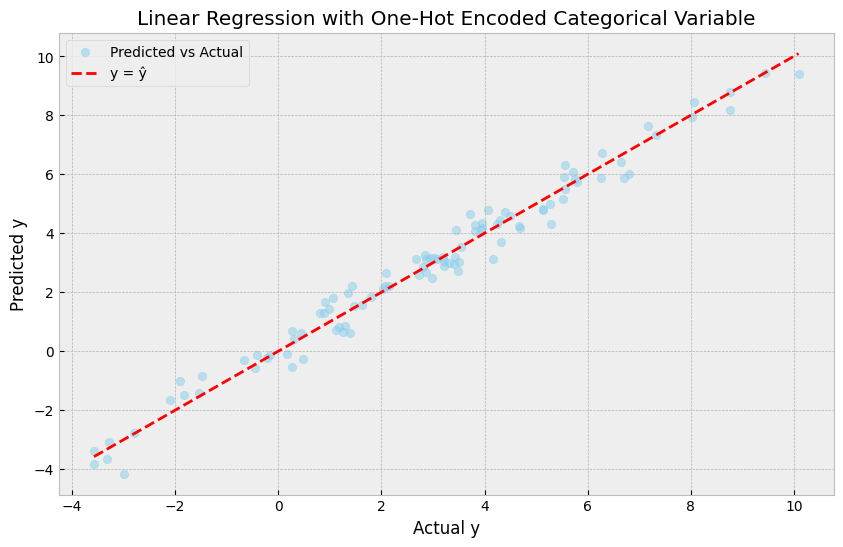

In [41]:
# Define one-hot encoding for categorical variable x2
x2_one_hot = pd.get_dummies(x2, prefix="x2").astype(int)

# Combine x1 and one-hot encoded x2 into a single DataFrame
X = pd.DataFrame({"x1": x1})
X = pd.concat([X, x2_one_hot], axis=1)

model = sm.OLS(y, X).fit()

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(
    y, model.predict(X), alpha=0.5, color="skyblue", label="Predicted vs Actual"
)
plt.xlabel("Actual y")
plt.ylabel("Predicted y")
plt.title("Linear Regression with One-Hot Encoded Categorical Variable")
plt.plot(
    [y.min(), y.max()],
    [y.min(), y.max()],
    color="red",
    linestyle="--",
    linewidth=2,
    label="y = ŷ",
)
plt.legend()
plt.grid(True)
plt.show()

#### Benefits of OLS
- Simplicity and Interpretability
- BLUE (Best Linear Unbiased Estimator); of all unbiased estimators, OLS has the lowest variance (highest confidence)
- Well-defined inference
- Computational Efficiency

#### Looking Ahead

In class 2:
1. How can we do inference on these $\beta$ values?
2. How do I understand what $\epsilon$ means?
3. What about outliers?